In [1]:
from typing import Union

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
import os

def incriment_file(base_filename: str, directory: str) -> None:
    """
    Determine the next incrimented version of the file nmae.

    :param base_filename: look for files with this name, then incriment them with a suffix underscore and number
    :param directory: the relative filepath to look inside of 

    :returns: file name incrimented appropriately
    """
    # Extract the name and extension
    name, ext = os.path.splitext(base_filename)
    path = os.path.join(directory, base_filename)

    # Check if the file already exists
    counter = 0
    while os.path.exists(path):
        # Add or update the suffix
        path = os.path.join(directory, f"{name}_{counter}{ext}")
        counter += 1

    return path

In [3]:
MODEL_EXPERIMENT_FILEPATH = 'experiments/models/experiment_number_{:04d}.pth'

In [4]:
experiment_filepath = 'experiments/experiments.json'

with open(experiment_filepath, 'r') as file:
    records = json.load(file)
    experiment_results_df = pd.DataFrame.from_records(records)

experiment_results_df.tail()

,num_epochs,mean_test_accuracy,std_test_accuracy,model_architecture,dropout_rate,activation_function,optimizer,learning_rate,optimizer_hyperparams,batch_normalization,weight_init
356,50,0.903418,0.025555,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.001,"{'betas': [0.999, 0.999]}",True,kaiming_uniform
357,50,0.902441,0.019106,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.001,"{'betas': [0.999, 0.999]}",True,kaiming_uniform
358,50,0.904395,0.020241,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.001,"{'betas': [0.999, 0.999]}",True,kaiming_uniform
359,50,0.905078,0.018492,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.001,"{'betas': [0.999, 0.999]}",True,kaiming_uniform
360,50,0.899609,0.022477,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.001,"{'betas': [0.999, 0.999]}",True,kaiming_uniform


In [58]:
# Mean test accuracy for the 5 trials of the best model
best_model_trials = [356, 357, 358, 359, 360]
experiment_results_df.iloc[best_model_trials].mean_test_accuracy.describe()

count    5.000000
mean     0.902988
std      0.002136
min      0.899609
25%      0.902441
50%      0.903418
75%      0.904395
max      0.905078
Name: mean_test_accuracy, dtype: float64

In [25]:
experiment_results_df.loc[experiment_results_df["mean_test_accuracy"].idxmax()]

num_epochs                                      50
mean_test_accuracy                        0.904883
std_test_accuracy                         0.016447
model_architecture                 [1024, 256, 10]
dropout_rate                            [0.5, 0.5]
activation_function                           relu
optimizer                                     Adam
learning_rate                                0.001
optimizer_hyperparams    {'betas': [0.999, 0.999]}
batch_normalization                           True
weight_init                        kaiming_uniform
Name: 351, dtype: object

In [38]:
from fashion_mnist_model import ACAIGFCN, FASHION_MNIST_INPUT_DIM, FASHION_MNIST_OUTPUT_DIM

eligible_activation_functions = {
    "relu": torch.nn.functional.relu,
}


def prepare_model_based_on_past_experiment(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    model = ACAIGFCN(
        input_dim=FASHION_MNIST_INPUT_DIM,
        output_dim=FASHION_MNIST_OUTPUT_DIM,
        hidden_layer_dims=exp_df.loc[experiment_number].model_architecture[:-1],
        activation_function=eligible_activation_functions[exp_df.loc[experiment_number].activation_function],
        dropout=exp_df.loc[experiment_number].dropout_rate,
        batch_norm=exp_df.loc[experiment_number].batch_normalization,
    )
    return model


def load_model(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    # model = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1))

    model = ACAIGFCN(
        input_dim=FASHION_MNIST_INPUT_DIM,
        output_dim=FASHION_MNIST_OUTPUT_DIM,
        hidden_layer_dims=exp_df.loc[experiment_number].model_architecture[:-1],
        activation_function=eligible_activation_functions[exp_df.loc[experiment_number].activation_function],
        dropout=exp_df.loc[experiment_number].dropout_rate,
        batch_norm=exp_df.loc[experiment_number].batch_normalization,
    )
    model_dict_and_metadata = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1), weights_only=False)
    model_state_dict = model_dict_and_metadata["model_state_dict"]
    model_dict_and_metadata.pop("model_state_dict")
    model.load_state_dict(model_state_dict)
    return model, model_dict_and_metadata


def plot_model_results(model_metadata: Union[dict, list[dict]], experiments: list[int], savefig: bool = True):
    if not model_metadata:
        raise ValueError('No model metadata provided')

    if isinstance(model_metadata, dict):
        model_metadata = [model_metadata]
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    
    for experiment_no, metadata in zip(experiments, model_metadata):
        label=f'Exp No. {experiment_no} (Test Acc: {metadata["mean_test_accuracy"]:.4f})'
        ax0.plot(metadata['train_loss'], label=label, alpha=0.65)
        ax2.plot(np.array(metadata['validation_loss'])[:,0], np.array(metadata['validation_loss'])[:,1], label=label)

        ax1.plot(metadata['train_accuracy'], label=label, alpha=0.65)
        ax3.plot(np.array(metadata['validation_accuracy'])[:,0], np.array(metadata['validation_accuracy'])[:,1], label=label)

    ax0.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax0.set_title('Training Loss')
    ax1.set_title('Training Accuracy')
    ax2.set_title('Validation Loss')
    ax3.set_title('Validation Accuracy')

    plt.suptitle('Model Training Results')
    plt.tight_layout()
    filename = incriment_file('model_training_results_vis.png', "visualizations")
    if savefig:
        plt.savefig(filename)
    plt.show()


def gather_metadata(experiments: list[int]):
    model_metadata = []
    for i in experiments:
        model, metadata = load_model(i, experiment_results_df)
        model_metadata.append(metadata)

    return model_metadata


In [54]:
def model_arch_filter(x: pd.DataFrame, desired_arch: list[int]) -> pd.Series:
    return x["model_architecture"] == desired_arch

experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 512, 10],))

no_batch_norm_rand_normal_mask = (
    experiment_results_df["batch_normalization"]
    & (experiment_results_df["weight_init"] == "xavier_uniform")
    & (experiment_results_df["optimizer"] == "Adam")
    # & (experiment_results_df["learning_rate"] == 0.01)
    & (experiment_results_df["num_epochs"] == 30)
    & experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 256, 10],))
)
no_batch_norm_rand_normal_mask.sum()

experiment_results_df[no_batch_norm_rand_normal_mask]

,num_epochs,mean_test_accuracy,std_test_accuracy,model_architecture,dropout_rate,activation_function,optimizer,learning_rate,optimizer_hyperparams,batch_normalization,weight_init
109,30,0.890625,0.021360,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.9]}",True,xavier_uniform
111,30,0.896680,0.022217,"[1024, 256, 10]","[0.3, 0.5]",relu,Adam,0.0010,"{'betas': [0.95, 0.9]}",True,xavier_uniform
113,30,0.893262,0.018924,"[1024, 256, 10]","[0.5, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.9]}",True,xavier_uniform


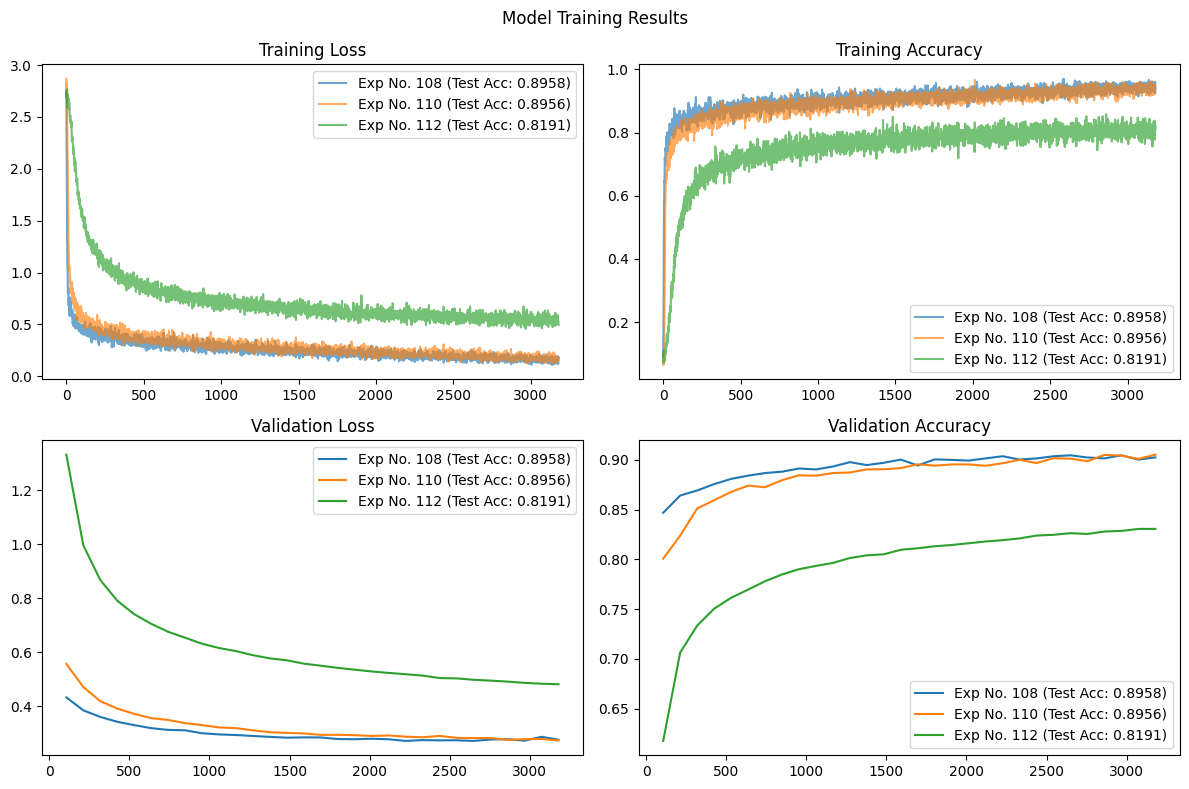

In [53]:
exps = experiment_results_df[no_batch_norm_rand_normal_mask].index.tolist()
model_metadata_list = gather_metadata(
    exps
)

plot_model_results(
    model_metadata_list,
    exps,
    savefig=True,
)

In [14]:
experiment_subset_mask = (
    (experiment_results_df["num_epochs"] == 30) &
    (experiment_results_df["batch_normalization"] == True) &
    (experiment_results_df["model_architecture"].apply(lambda x: tuple(x)) == (1024, 256, 10)) &
    (experiment_results_df["optimizer"] == "Adam")
)

experiment_results_df[experiment_subset_mask]

,num_epochs,mean_test_accuracy,std_test_accuracy,model_architecture,dropout_rate,activation_function,optimizer,learning_rate,optimizer_hyperparams,batch_normalization,weight_init
109,30,0.890625,0.021360,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.9]}",True,xavier_uniform
111,30,0.896680,0.022217,"[1024, 256, 10]","[0.3, 0.5]",relu,Adam,0.0010,"{'betas': [0.95, 0.9]}",True,xavier_uniform
113,30,0.893262,0.018924,"[1024, 256, 10]","[0.5, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.9]}",True,xavier_uniform
121,30,0.890332,0.016788,"[1024, 256, 10]","[0.2, 0.1]",relu,Adam,0.0100,"{'betas': [0.9, 0.95]}",True,random_normal
123,30,0.880762,0.020222,"[1024, 256, 10]","[0.3, 0.2]",relu,Adam,0.0010,"{'betas': [0.9, 0.99]}",True,random_normal
125,30,0.842383,0.030100,"[1024, 256, 10]","[0.3, 0.2]",relu,Adam,0.0001,"{'betas': [0.95, 0.99]}",True,random_normal
133,30,0.102148,0.018786,"[1024, 256, 10]","[0.5, 0.5]",relu,Adam,0.0100,"{'betas': [0.99, 0.9]}",True,kaiming_uniform
135,30,0.891211,0.017568,"[1024, 256, 10]","[0.1, 0.1]",relu,Adam,0.0010,"{'betas': [0.99, 0.95]}",True,kaiming_uniform
137,30,0.898828,0.017595,"[1024, 256, 10]","[0.2, 0.2]",relu,Adam,0.0001,"{'betas': [0.9, 0.9]}",True,kaiming_uniform


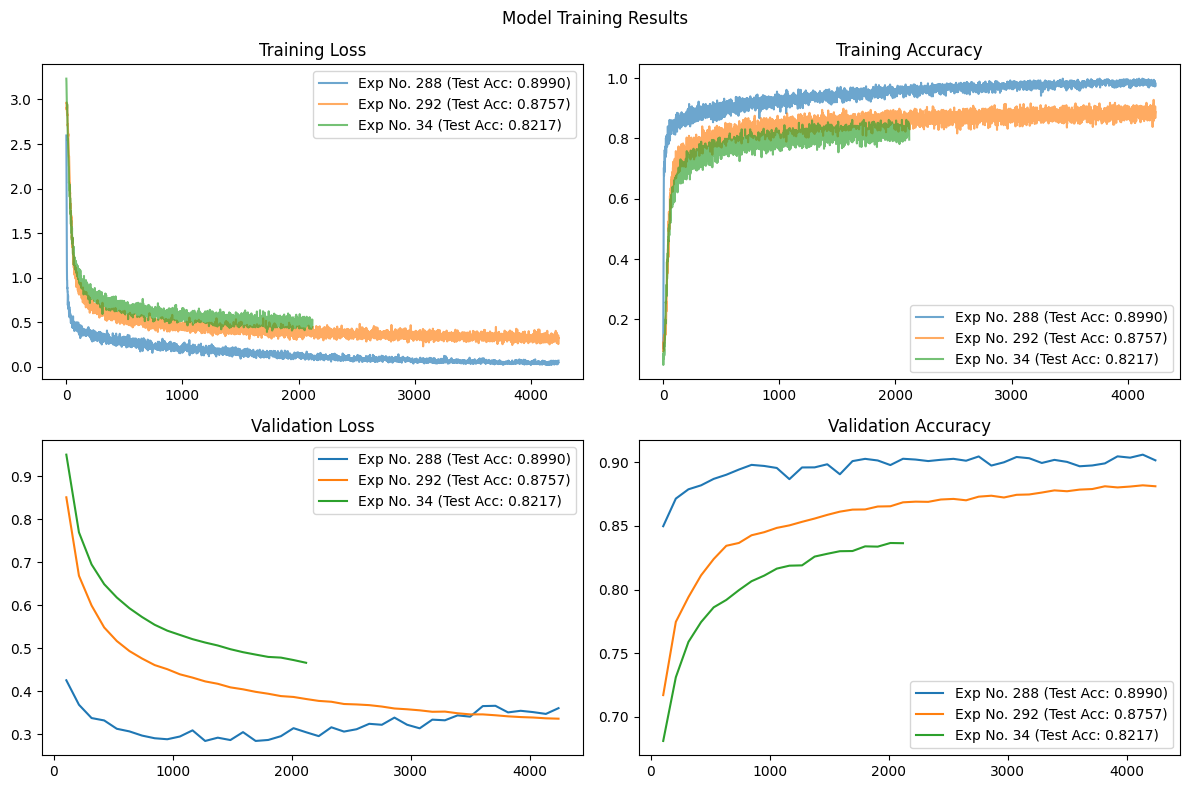

In [19]:
# experiments = experiment_results_df[np.random.randint(0, experiment_results_df.shape[0], 5).tolist()].index
experiments = np.random.randint(0, experiment_results_df.shape[0], 3).tolist()
model_metadata_list = gather_metadata(experiments)

plot_model_results(model_metadata_list, experiments, savefig=False)